In [4]:
!pip install sklearn --upgrade
!pip install keras

Requirement already up-to-date: sklearn in /Users/jtorrez/anaconda2/lib/python2.7/site-packages
Requirement already up-to-date: scikit-learn in /Users/jtorrez/anaconda2/lib/python2.7/site-packages (from sklearn)


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
sns.set_style("dark")
sns.set_context("talk")

# Data Analysis

In [3]:
data_path = '~/sbox/d4d/far-right-analysis/hate-speech-classifier/data/labeled-twitter-hate-speech.csv'

df = pd.read_csv(data_path, encoding='latin1')
df = df.rename(columns={'does_this_tweet_contain_hate_speech': 'label',  
                        'does_this_tweet_contain_hate_speech:confidence': 'confidence' })

mapping = {'The tweet is not offensive': 'Not offensive', 
           'The tweet uses offensive language but not hate speech': 'Offensive',
           'The tweet contains hate speech': 'Hate speech'
          }
df['label'] = df['label'].map(lambda x: mapping[x])

In [4]:
gold = df[df['_golden']].dropna(axis=1)
data = df[~df['_golden']].dropna(axis=1)

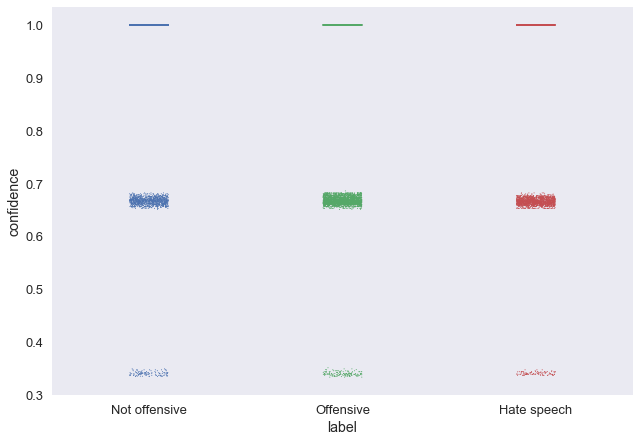

In [16]:
sns.stripplot(x="label", y="confidence", data=data, size=1, jitter=True);

In [17]:
data['label'].value_counts()

Not offensive    7253
Offensive        4807
Hate speech      2382
Name: label, dtype: int64

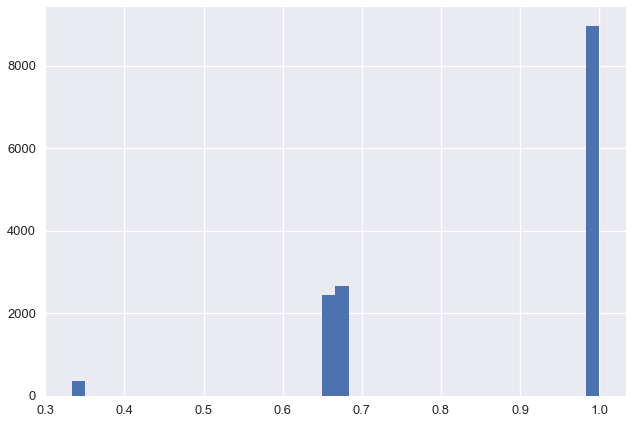

In [18]:
data['confidence'].hist(bins=40);

# Preprocessing

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import SelectFromModel

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

In [21]:
vectorizer = TfidfVectorizer(encoding='latin1', min_df=5)

X = vectorizer.fit_transform(data['tweet_text'])
y = data['label'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [22]:
X_train.shape

(12997, 3282)

### Dimentionality reduction

In [23]:
#pca = PCA(n_components=100)
#X_features = pca.fit_transform(X_train.toarray())

lsvc = LinearSVC(C=0.1, penalty="l1", dual=False).fit(X, y)
lsvc_select = SelectFromModel(lsvc, prefit=True)
X_train = lsvc_select.transform(X_train)
X_test = lsvc_select.transform(X_test)

### Training

In [24]:
clf = SVC(class_weight='balanced')
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [26]:
label = 0
top = 20

for i in clf.coef_[label, :].argsort()[::-1][:top]:
    print(i, clf.coef_[0, i], vectorizer.get_feature_names()[i])

69 7.69866407889 abuse
144 7.21269156525 always
68 6.92017754984 abt
145 6.54944676776 am
228 4.63806830056 ass
70 4.33736270237 abused
67 4.06105952562 absolutely
114 3.89353152839 ahh
61 3.64985076665 ability
136 3.36279730425 allowed
165 3.21246525594 announced
213 3.17738457121 aryan
164 3.17192958738 anime
46 3.04240877939 925
139 2.7773845133 along
142 2.58936131818 also
182 2.58615308072 apartment
88 2.57083706876 add
91 2.54942133187 adele
71 2.48520672793 acc


In [27]:
clf.classes_

array(['Hate speech', 'Not offensive', 'Offensive'], 
      dtype='<U13')

In [28]:
c = clf.coef_.sum(axis=0).argsort()

### Grid Search

In [29]:
param_grid = [
  {'C': [1, 10, 100, 1000]}
]

clf = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [1, 10, 100, 1000]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

### Evaluation

In [30]:
preds = clf.predict(X_test)
print(classification_report(y_test, preds))

               precision    recall  f1-score   support

  Hate speech       0.56      0.59      0.57       238
Not offensive       0.90      0.95      0.93       726
    Offensive       0.73      0.65      0.69       481

  avg / total       0.79      0.79      0.79      1445



# Feature extraction

In [32]:
from textblob import TextBlob

ImportError: No module named 'textblob'

In [22]:
text = 'this sucks'

In [23]:
blob = TextBlob(text)
blob.sentiment

Sentiment(polarity=-0.3, subjectivity=0.3)

# Keras POC

In [33]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
import keras

Using Theano backend.


In [34]:
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence, one_hot, Tokenizer

from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.utils import to_categorical
from keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE

In [65]:
X = data['tweet_text'].tolist()

# Encode labels
mapping = {l: i for i, l in enumerate(sorted(data['label'].unique()))}
reverse_mapping = {i: l for l, i in mapping.items()}

label_names = sorted(mapping.keys())
y = data['label'].map(lambda x: mapping[x])
y = to_categorical(y, num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [66]:
X_test_text = X_test

In [67]:
max_features = 4000
maxlen = 30
batch_size = 32

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)

X_train shape: (11553, 30)
X_test shape: (2889, 30)
y_train shape: (11553, 3)


In [68]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         512000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 643,971.0
Trainable params: 643,971
Non-trainable params: 0.0
_________________________________________________________________


In [69]:
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=3,
          validation_data=(X_test, y_test));

Train on 11553 samples, validate on 2889 samples
Epoch 1/3
11553/11553 [==============================] - 42s - loss: 0.6641 - acc: 0.7061 - val_loss: 0.4935 - val_acc: 0.7729

2784/2889 [===========================>..] - ETA: 0s

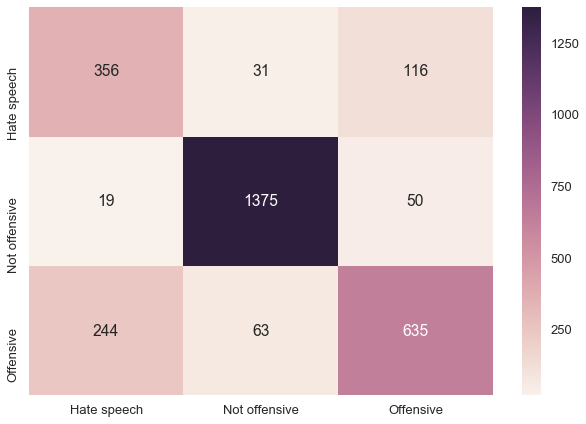

In [70]:
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('\nTest score:', score, 'Test accuracy:', acc)

pred_probas = model.predict(X_test)
pred_labels = np.argmax(pred_probas, axis=1)
true_labels = np.argmax(y_test, axis=1)
print('\n', classification_report(true_labels, pred_labels))

cnf = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cnf, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names);

### Dataviz

In [71]:
from bokeh.charts import Scatter, output_file, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool
output_notebook()

Loading BokehJS ...

In [72]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         512000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 643,971.0
Trainable params: 643,971
Non-trainable params: 0.0
_________________________________________________________________


In [73]:
layer_name = 'lstm_2'
layer_output = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
embeddings = layer_output.predict(X_test)

In [ ]:
model_tsne = TSNE(n_components=2, random_state=0)
tsne = model_tsne.fit_transform(embeddings) 

In [63]:
tsne_df = pd.DataFrame()
tsne_df['x'] = tsne[:, 0]
tsne_df['y'] = tsne[:, 1]
tsne_df['label'] = [reverse_mapping[l] for l in true_labels]
tsne_df['text'] = X_test_text
tsne_df['error'] = true_labels != pred_labels

In [64]:
p = Scatter(tsne_df, x='x', y='y', color='label', marker='error', plot_height=900, plot_width=900, 
             tooltips=[('Text', '@text'), ('Error', '@error'), ('Label', '@label')]
)

show(p)